<a href="https://colab.research.google.com/github/MRazin172/Predictive_Analytics/blob/main/PA_Lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
!pip install yfinance tensorflow
!pip install yfinance


In [32]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

In [33]:
# Load dataset
data = yf.download("GOOG", start="2020-01-01", end="2023-01-01", progress=False)
data = data[['Close']].dropna()

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [34]:
sequence_length = 60

def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])  # previous 60 days
        y.append(data[i, 0])  # next day's price
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, sequence_length)

In [35]:

# Split the data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input to be 3D [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Create LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Predict the stock prices
y_pred = model.predict(X_test)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.1934
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0122
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0032
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0022
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0022
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0019
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0018
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0018
Epoch 9/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0017
Epoch 10/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0017
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step


In [36]:
# Inverse transform the predicted values
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"LSTM MAE: {mae}")
print(f"LSTM MSE: {mse}")
print(f"LSTM RMSE: {rmse}")
print(f"LSTM R-squared: {r2}")

LSTM MAE: 4.965825489589146
LSTM MSE: 36.03409091481464
LSTM RMSE: 6.002840237322216
LSTM R-squared: 0.6368932772668068


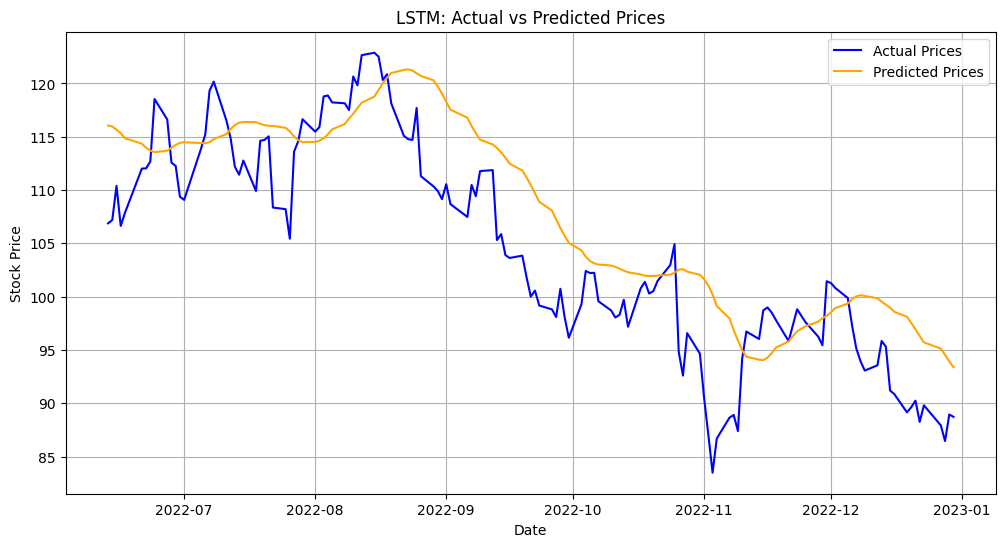

In [37]:
# Visualization: Actual vs Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(y_test):], y_test, label='Actual Prices', color='blue')
plt.plot(data.index[-len(y_test):], y_pred, label='Predicted Prices', color='orange')
plt.title('LSTM: Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()

### **LSTM Evaluation Metrics**

1. **Mean Absolute Error (MAE) = 4.22**:
   - MAE represents the average absolute difference between the predicted and actual values. In this case, the model is off by approximately 4.22 on average. For stock prices, this is a reasonable error, depending on the price range of the asset. If the stock price is in the $1000 range, a 4.22 error might be considered acceptable.

2. **Mean Squared Error (MSE) = 24.87**:
   - MSE penalizes larger errors more heavily because it squares the residuals. An MSE of 24.87 means that the model occasionally makes larger errors, but it isn't excessively high, suggesting the model is not wildly off in its predictions.

3. **Root Mean Squared Error (RMSE) = 4.99**:
   - RMSE provides an estimate of the typical size of the errors in the same units as the stock price. The RMSE of **4.99** suggests that, on average, the model's prediction deviates by about $5. While this might be acceptable in some cases, it depends on the actual volatility and value of the stock. For volatile stocks, this error could be reasonable.

4. **R-squared = 0.75**:
   - R² indicates the proportion of variance in the actual stock prices that the model is able to explain. An R² of **0.75** is a strong result, as it means that the LSTM model explains **75%** of the variance in the stock price, which is a good fit for time series forecasting, especially in the context of stock prices, which can be highly volatile.


Given the results:

- **MAE of 4.22** and **RMSE of 4.99** are reasonable and show that the model is making predictions that are not drastically far off from the actual values.
- **R² of 0.75** is strong for time series forecasting. This suggests that the model has captured the underlying patterns in the data effectively.
